# 1. Description and data generation

## 1.1 Introduction 
Heart rate variability (HRV) is the physiological phenomenon of variation in the lengths of consecutive cardiac cycles, or the rhythm of heart rate. In short, HRV results from an integration of complicated interactions between various physiological systems and external stimuli on various scales, and the autonomic nervous system (ANS) plays a critical role. A correct quantification of HRV yields dynamical information of various physiological systems and has various clinical applications, including improving diagnostic accuracy and treatment quality

In practice, the heart rhythm is quantified by the time series called instantaneous heart rate (IHR) coming from intervals between consecutive pairs of heart beats, which is usually determined from the R peak to R peak interval (RRI) by reading the electrocardiogram (ECG).

Here, we use TDA (topological data analysis) in order to get the desired results using persistence diagrams. Specifically, there have been several efforts applying TDA to analyze time series. For example, the Vietoris-Rips (VR) complex filtrations. However, existing TDA approaches usually suffer from computational issues, which limits its application to large scale database. Finding a computationally efficient TDA algorithm is thus critical.

To demonstrate the usefulness of the proposed persistence statistics, we apply it to study IHR time series recorded during sleep, and use obtained statistics to classify sleep stages

In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statistics import mean
import gudhi as gdh
import sys

In [3]:
number_of_subjects = 73
number_of_readings_per_subject = 1001

## 1.2 Data generating 

With a certain probability a random generated value will be NaN (so we can simulate it as closely as possible to the real world counter-part).
The function below generates random data points ranging from 0.5 to 1 and returns an adequate pandas dataset.

In [4]:
def generate_random_value_point(probability):
    if(np.random.random() > probability):
        return np.nan
    elif (np.random.random() > probability * probability):
        return (np.random.random()+1)/2
    #return different random value, else every value close to 1 would be NaN 
    return (np.random.random()+1)/2

def generate_random_data(number_of_subjects, points_per_subject):
    dataset = np.zeros((number_of_subjects, points_per_subject))
    for k in range(number_of_subjects):
        for i in range(points_per_subject):
            r_k_i = generate_random_value_point(probability = 0.89)
            dataset[k][i] = r_k_i

    #set dataset column names (generic)
    data_columns = [f"r_{i}" for i in range(points_per_subject)]
    dataset = pd.DataFrame(dataset, columns = data_columns)
    
    return dataset

In [5]:
dataset = generate_random_data(number_of_subjects, number_of_readings_per_subject)
dataset = dataset.fillna(0.75) # FIX

We try and determine whether or not the subject is asleep (it's practically reverse engineering since we're getting labels from the data rather than getting info on the data based on labels)

In [6]:
wake_status = [mean(dataset.iloc[k]) for k in range(number_of_subjects)]
wake_status = ["Awake" if x > 0.75 else "Asleep" for x in wake_status]

dataset["wake_status"] = wake_status

In [7]:
dataset

,r_0,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,...,r_992,r_993,r_994,r_995,r_996,r_997,r_998,r_999,r_1000,wake_status
0,0.809308,0.589879,0.586617,0.756903,0.725540,0.828077,0.751872,0.638553,0.759359,0.536876,...,0.753119,0.544848,0.961566,0.844261,0.655960,0.711845,0.605548,0.750417,0.677787,Asleep
1,0.566987,0.910211,0.800620,0.743325,0.949668,0.770168,0.874793,0.986418,0.968463,0.750000,...,0.626966,0.821217,0.600983,0.963802,0.734704,0.961027,0.754655,0.750000,0.934447,Asleep
2,0.591131,0.878806,0.957056,0.611993,0.539048,0.963550,0.682326,0.654906,0.936302,0.607932,...,0.947883,0.837647,0.750000,0.807760,0.949961,0.535240,0.719402,0.669533,0.969544,Awake
3,0.703524,0.744169,0.747299,0.906507,0.819070,0.946368,0.750000,0.571542,0.646504,0.773793,...,0.696170,0.535356,0.692060,0.743595,0.739508,0.979648,0.750000,0.946937,0.880724,Asleep
4,0.639917,0.750000,0.752921,0.922303,0.589605,0.783690,0.750000,0.750000,0.589937,0.635641,...,0.746627,0.980664,0.803091,0.980538,0.837559,0.898563,0.750000,0.935315,0.641695,Awake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.821411,0.750000,0.700094,0.750000,0.841354,0.682424,0.515374,0.717295,0.869767,0.719508,...,0.719880,0.613199,0.708667,0.744102,0.750000,0.655285,0.885445,0.514564,0.818122,Asleep
69,0.647328,0.757683,0.750000,0.750000,0.792669,0.927960,0.600492,0.988872,0.974323,0.686914,...,0.980881,0.805263,0.745972,0.553729,0.851602,0.910111,0.750000,0.577760,0.883203,Awake
70,0.764174,0.750000,0.860201,0.542854,0.520030,0.925786,0.633627,0.577804,0.599799,0.675086,...,0.750000,0.845776,0.516097,0.834705,0.787688,0.799475,0.508664,0.730456,0.582221,Awake
71,0.776668,0.882207,0.682924,0.676021,0.775047,0.883222,0.754254,0.706412,0.640761,0.750000,...,0.544285,0.944507,0.777165,0.567785,0.933704,0.765520,0.629188,0.502541,0.981570,Asleep


## 1.3 Data normalization
In order to get useful results from TDA we need to transform the data so it's uniform (we decide to just normalize the data here)

In [8]:
def normalizeDataset(dataset):
    numeric_cols = dataset.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        min_val = dataset[col].min()
        max_val = dataset[col].max()
    
        dataset[col] = (dataset[col] - min_val) / (max_val - min_val)
    
    return dataset

In [9]:
dataset = normalizeDataset(dataset)

# 2. Computing Persistence diagrams and Persistence landscapes

## 2.1 Persistence diagrams

To introduce Vietoris-Rips (VR) complexes filtration for a given time series, we first embed the time series into a high dimension point cloud

In general, given a point cloud, the main idea of Vietoris-Rips complex is to build simplicial complexes from it (if points are close enough)

We use the function below to create a persistence diagram for a given point cloud

In [10]:
def createPersistenceDiagram(pointCloud, printGraph = False, memorySaving = True):
    simplex = gdh.RipsComplex(points = pointCloud)
    simplex = simplex.create_simplex_tree(max_dimension = 2)
    barcodes = simplex.persistence()

    if memorySaving:
        simplex = simplex.persistence_intervals_in_dimension(1)
    if printGraph:
        gdh.plot_persistence_diagram(barcodes)

    return simplex

/home/ryu/.local/lib/python3.10/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


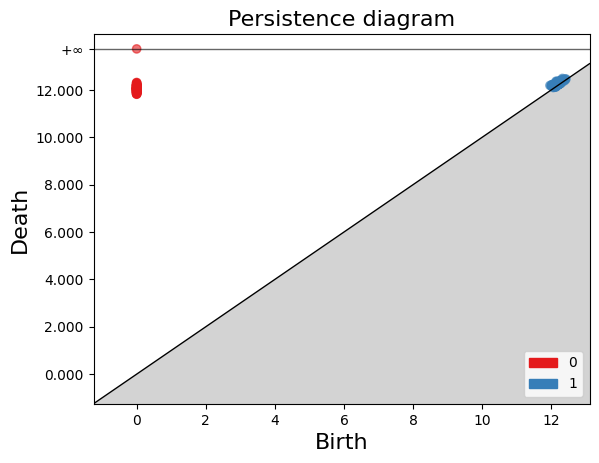

In [11]:
# deciding to use pure data without corresponding labels
usable_data = dataset.drop("wake_status", axis=1)

pointCloud = usable_data[0:100]
pointCloud_array = np.array(pointCloud)
diagram = createPersistenceDiagram(pointCloud_array, True, True)

Here we generate all persistence diagrams using the function above, we fixate the so called window size with the parameter omega

In [13]:
def getAllPersistenceDiagrams(dataset, omega, memorySaving = True):
    diagrams = []
    for i in range(len(dataset) - omega):
        pointCloud = np.array(dataset[i:i+omega])
        diagram = createPersistenceDiagram(pointCloud, False, True)
        diagrams.append(diagram)

    return diagrams

In [14]:
probni_dijagram = getAllPersistenceDiagrams(usable_data, 7, True)

In [15]:
# for i in range (66):
#     plt.plot(probni_dijagram[i])
#     plt.show()

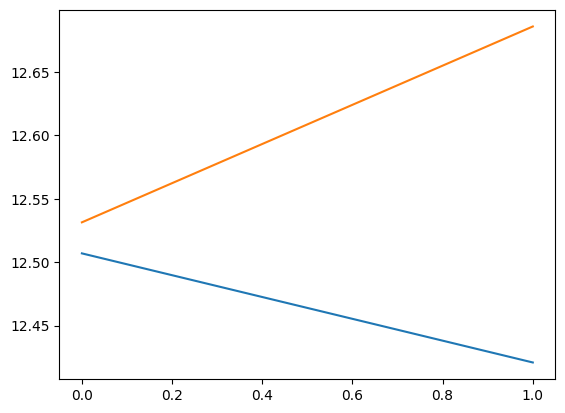

In [16]:
plt.plot(probni_dijagram[0])

## 2.2 Persitence landscapes
Persistent landscape is an array that transforms a persistent diagram into an n-dimensional space (here it's a Banach space). The result can be then be analized using statistical tools and machine learning (which is the main goal)

The function below takes a persistence diagram and computes the corresponding persistence landscape. The function creates a broken line from the "highs" and "lows" from diagram endpoints. The highs (represented in peaks in the diagram) is what interests us, they show a structure that lives longer than others of the same kind

Landscapes is an integer that limits the number of landscapes created.

In [17]:
def getPerstitenceLandscape(diagram, endpoints, landscapes, resolution):
    if endpoints[0] == endpoints[1] == 0:
        return np.zeros((landscapes, resolution))

    diagram_range = endpoints
    x_range =  np.linspace(diagram_range[0], diagram_range[1], resolution)
    step = x_range[1] - x_range[0]
    length_diagram = len(diagram)
    computed_landscapes_at_given_resolution = np.zeros([landscapes, resolution])
    computed_y_values = [[] for _ in range(resolution)]

    compute_x_subrange = lambda x: int(np.ceil(x/step))

    for x, y in diagram:
        min_point = x - diagram_range[0]
        mid_point = (x+y)/2 - diagram_range[0]
        max_point = y - diagram_range[0]
        minimum_x = compute_x_subrange(min_point)
        middle_x  = compute_x_subrange(mid_point)
        maximum_x = compute_x_subrange(max_point)

        if minimum_x < resolution and maximum_x > 0:
            y_value = diagram_range[0] + minimum_x*step - x
            for i in range(minimum_x, middle_x):
                computed_y_values[i].append(y_value)
                y_value += step
            y_value = y - diagram_range[0] - middle_x*step
            for i in range(middle_x, maximum_x):
                computed_y_values[i].append(y_value)
                y_value -= step

    for i in range(resolution):
        computed_y_values[i].sort(reverse=True)
        max_range = min(landscapes, len(computed_y_values[i]))
        for j in range(max_range):
            computed_landscapes_at_given_resolution[j,i] = computed_y_values[i][j]
    
    #np.nadarray  
    return computed_landscapes_at_given_resolution

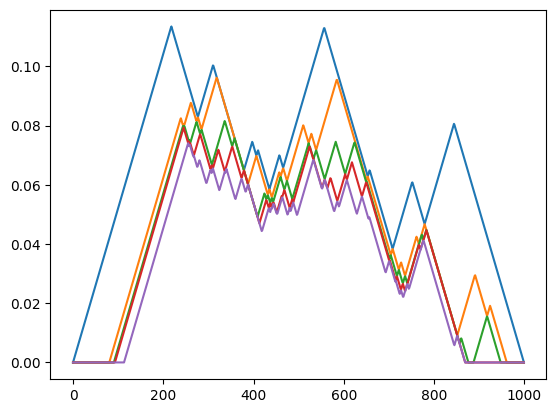

In [18]:
example_landscape = getPerstitenceLandscape(diagram,[np.min(diagram), np.max(diagram)], 5, 1000)
plt.plot(example_landscape.T);

The function creates landscapes using all diagrams. Diagrams are used as one array. That diagram (array) is used to generate all of the corresponind landscapes for that diagram.

In [28]:
def compute_endpoint(d, minmax):
            d = d.persistence_intervals_in_dimension(k)
            if len(d) > 0 and minmax=="min": return np.min(d)
            elif len(d) > 0 and minmax=="max": return np.max(d)
            else: return 0

def getAllPersistenceLandscapes(diagrams, landscapes, resolution, memory_saving):
    if memory_saving:
        minp = lambda d: np.min(d) if len(d) > 0 else 0
        maxp = lambda d: np.max(d) if len(d) > 0 else 0
    else:
        minp = lambda d: compute_endpoint(d, "min")
        maxp = lambda d: compute_endpoint(d, "max")

    landscapes = [
        getPerstitenceLandscape(
            diag,                     # diagram D
            [minp(diag), maxp(diag)], # endpoints
            landscapes,               # m landscapes
            resolution,               # n nodes
        ) for diag in diagrams
    ]
    return landscapes

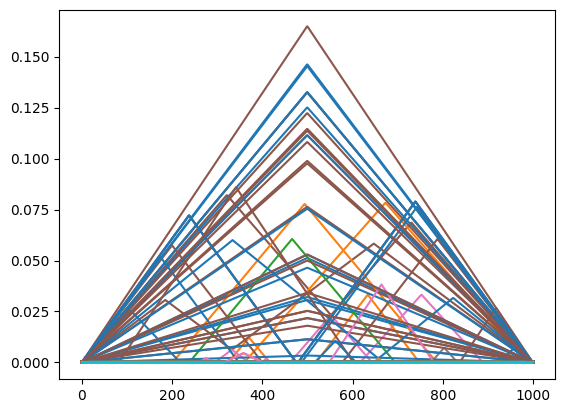

In [20]:
example_landscapes = getAllPersistenceLandscapes(probni_dijagram, 5, 1000, True)
for l in example_landscapes:
    plt.plot(l.T)

## 2.3 Norm computing
L1 and L2 norms is enough for our case.

The sys.float_info.epsilon is a python system generated small value (epsilon) used to prevent an interpretor error if it has to divide by zero.

In [21]:
def getNormsOfPersistenceLandscapes(landscapes):
    norms1 = [np.linalg.norm(ls, 1) for ls in landscapes]
    norms1 = norms1/(np.linalg.norm(norms1) + sys.float_info.epsilon)
    
    norms2 = [np.linalg.norm(ls, 2) for ls in landscapes]
    norms2 = norms2/(np.linalg.norm(norms2) + sys.float_info.epsilon)
    
    return np.array([norms1, norms2]).T

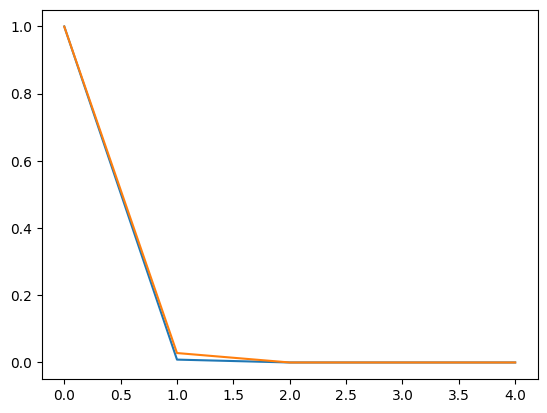

In [22]:
norms = getNormsOfPersistenceLandscapes(example_landscapes[0])
df = pd.DataFrame(norms, columns = ["L1", "L2"])
plt.plot(df)

In [23]:
n = len(example_landscapes)
norms = []
for l in example_landscapes:
    norms_df = getNormsOfPersistenceLandscapes(l)
    df = pd.DataFrame(norms_df, columns = ["L1", "L2"])
    norms.append(df)

L1_norms = np.array([norms_df["L1"] for norms_df in norms]).T
L1_norms = pd.DataFrame(L1_norms, columns = [f"var_{v+1}" for v in range(n)])

L2_norms = np.array([norms_df["L2"] for norms_df in norms]).T
L2_norms = pd.DataFrame(L1_norms, columns = [f"var_{v+1}" for v in range(n)])

<Axes: >

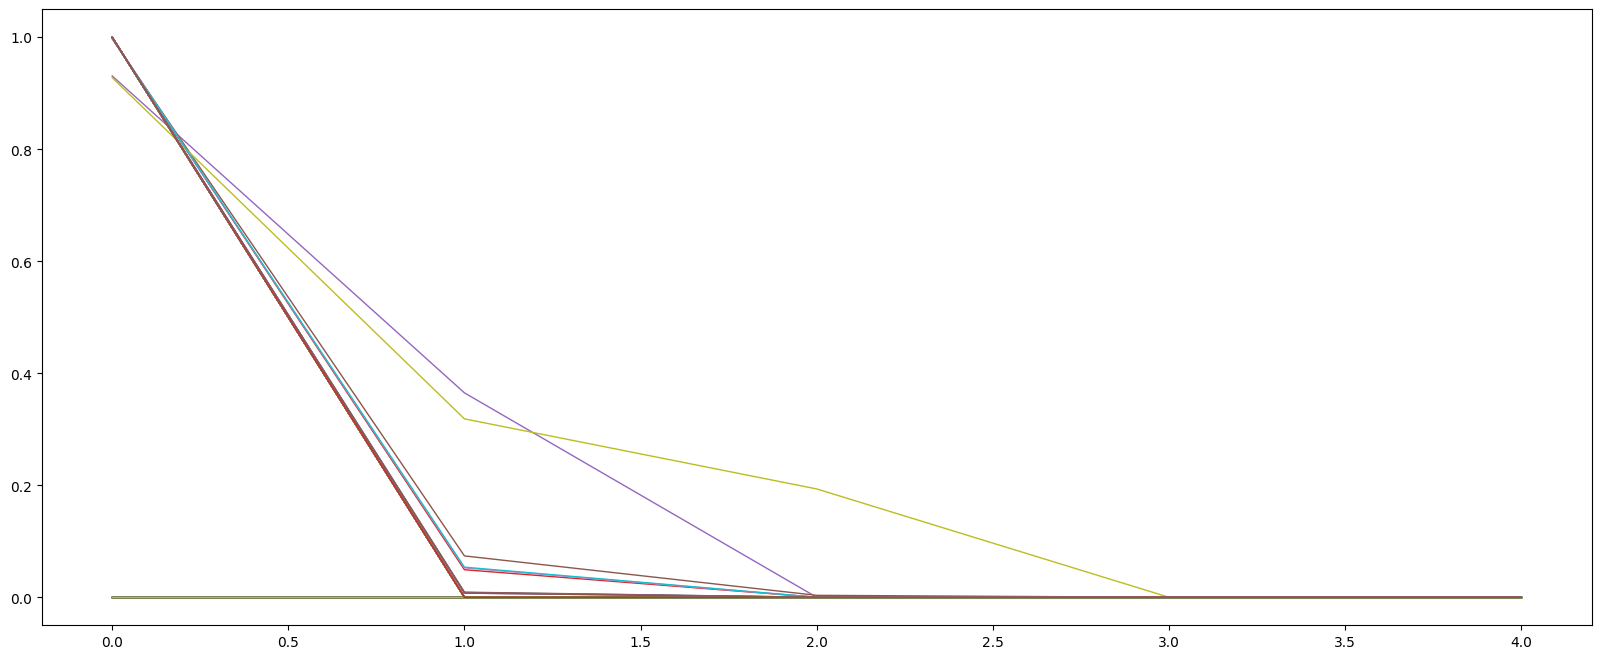

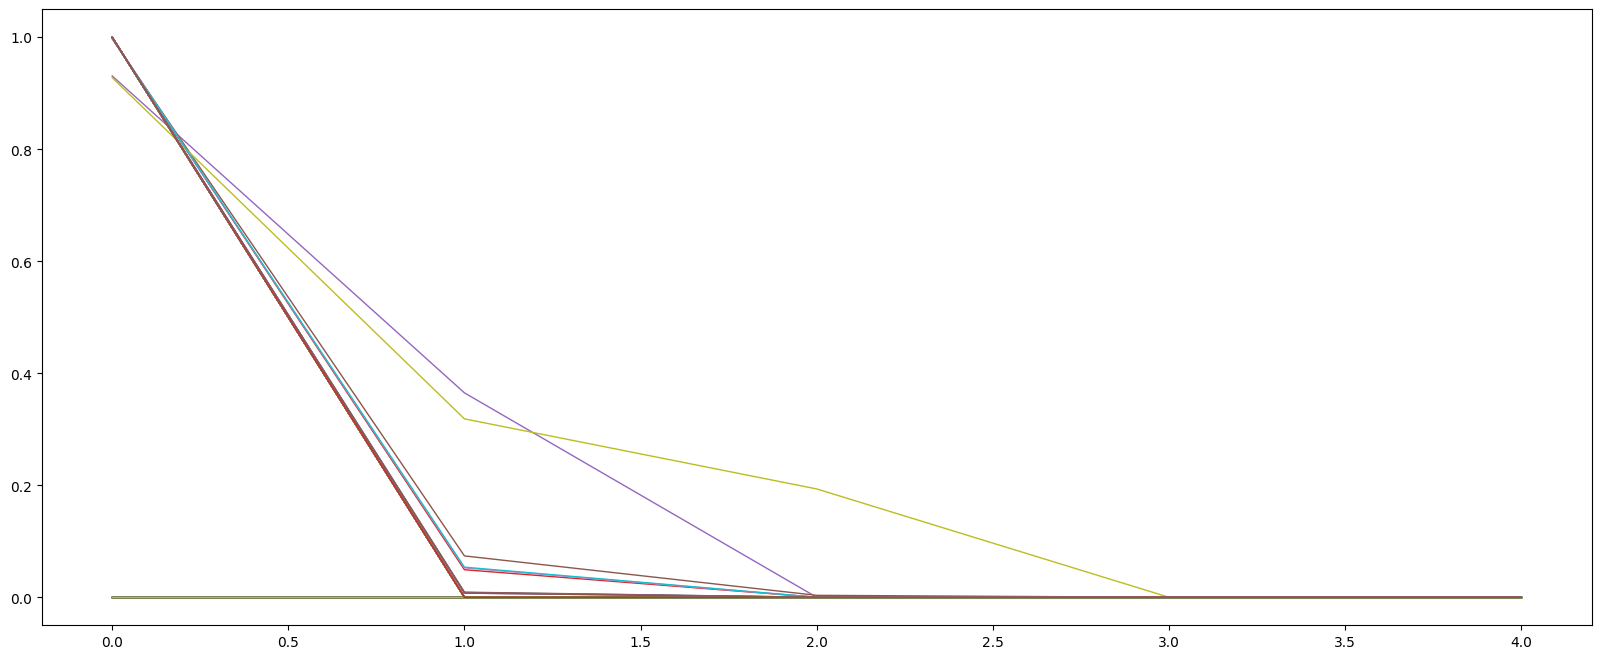

In [29]:
L1_norms.plot(figsize = (20, 8), lw = 1, legend = [])
L2_norms.plot(figsize = (20, 8), lw = 1, legend = [])

<Axes: >

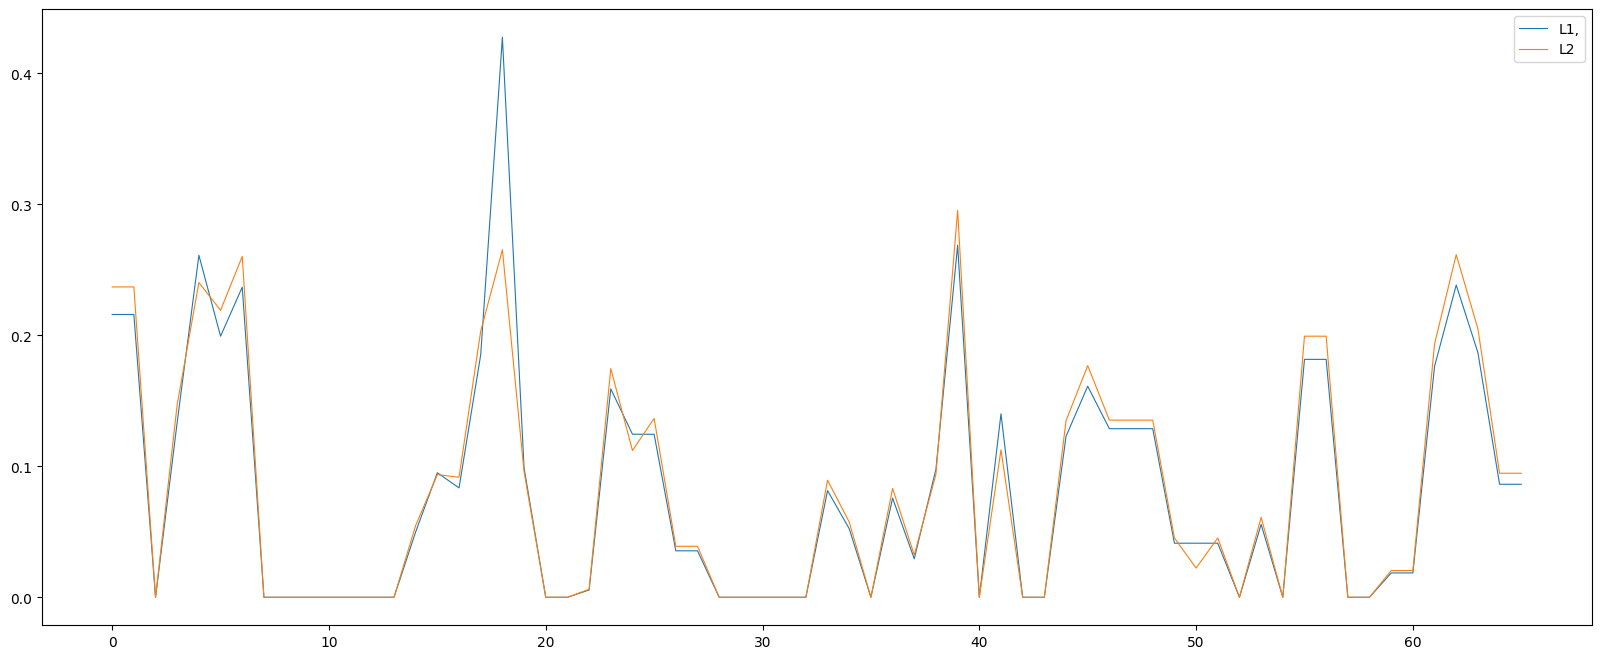

In [25]:
norms_df = getNormsOfPersistenceLandscapes(example_landscapes)
df = pd.DataFrame(norms_df, columns = ["L1,", "L2"])
df.plot(figsize = (20, 8), lw = 0.8)

# 3 Applying the functions
Everything done so far is done in a single function called <b>sleep_wake</b> which takes the adequate data and generates the landscapes (based on valid diagrams) 

In [26]:
def sleep_wake(starting_index, data_size, landscapes, window_size, n_nodes, memory_saving):
    #data setup
    data = usable_data.T

    #computing diagrams and landscapes
    diagrams = getAllPersistenceDiagrams(data, window_size, memory_saving)
    landscapes = getAllPersistenceLandscapes(diagrams, landscapes, n_nodes, memory_saving)

    #computing L1 and L2 norms
    n = len(landscapes)
    norms_dfs = []
    for l in landscapes:
        norms_df = getNormsOfPersistenceLandscapes(l)
        df = pd.DataFrame(norms_df, columns = ["L1", "L2"])
        norms_dfs.append(df)
    
    L1_norms = np.array([norms_df["L1"] for norms_df in norms_dfs]).T
    L1_norms = pd.DataFrame(L1_norms, columns = [f"var_{v+1}" for v in range(n)])
    
    L2_norms = np.array([norms_df["L2"] for norms_df in norms_dfs]).T
    L2_norms = pd.DataFrame(L1_norms, columns = [f"var_{v+1}" for v in range(n)])

    #plotting norms
    norms_df = getNormsOfPersistenceLandscapes(landscapes)
    df = pd.DataFrame(norms_df, columns = ["L1,", "L2"])
    df.plot(figsize = (20, 8), lw = 0.8)


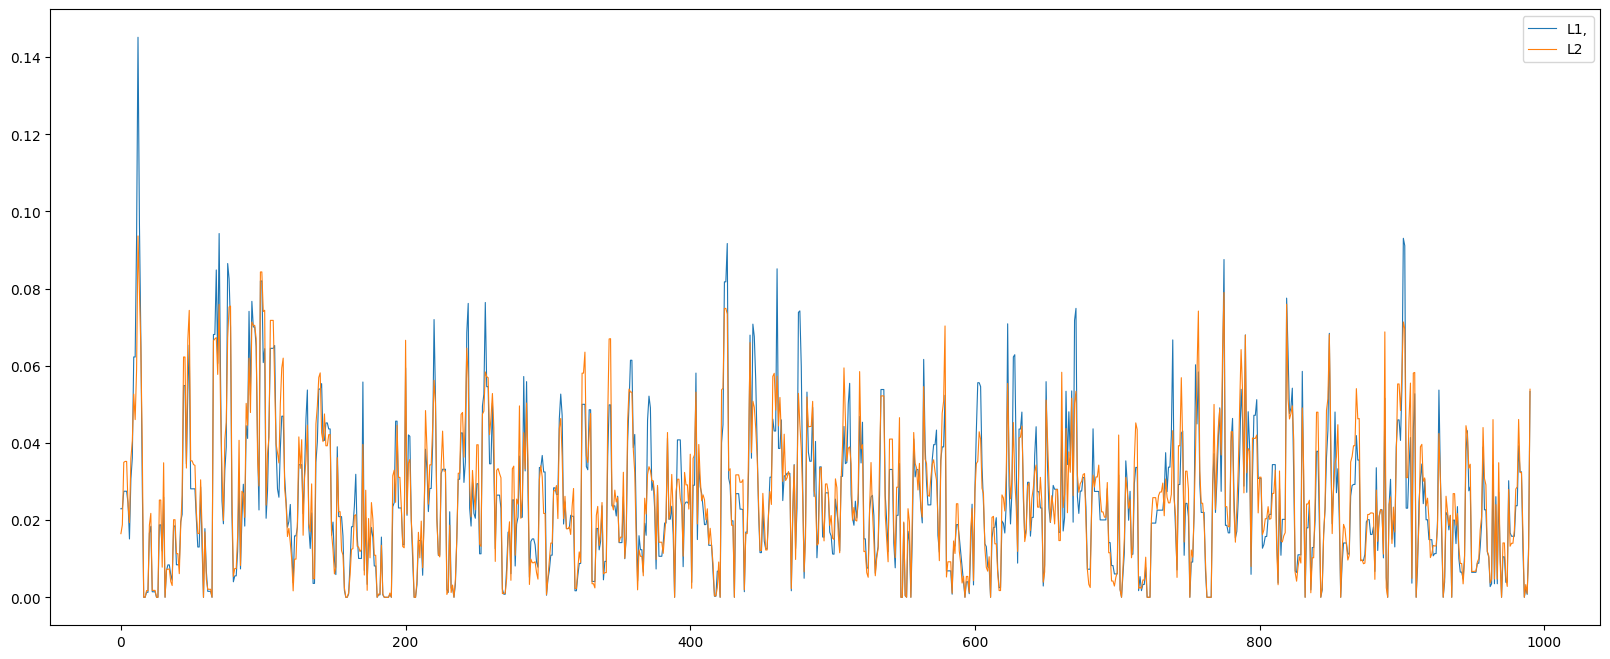

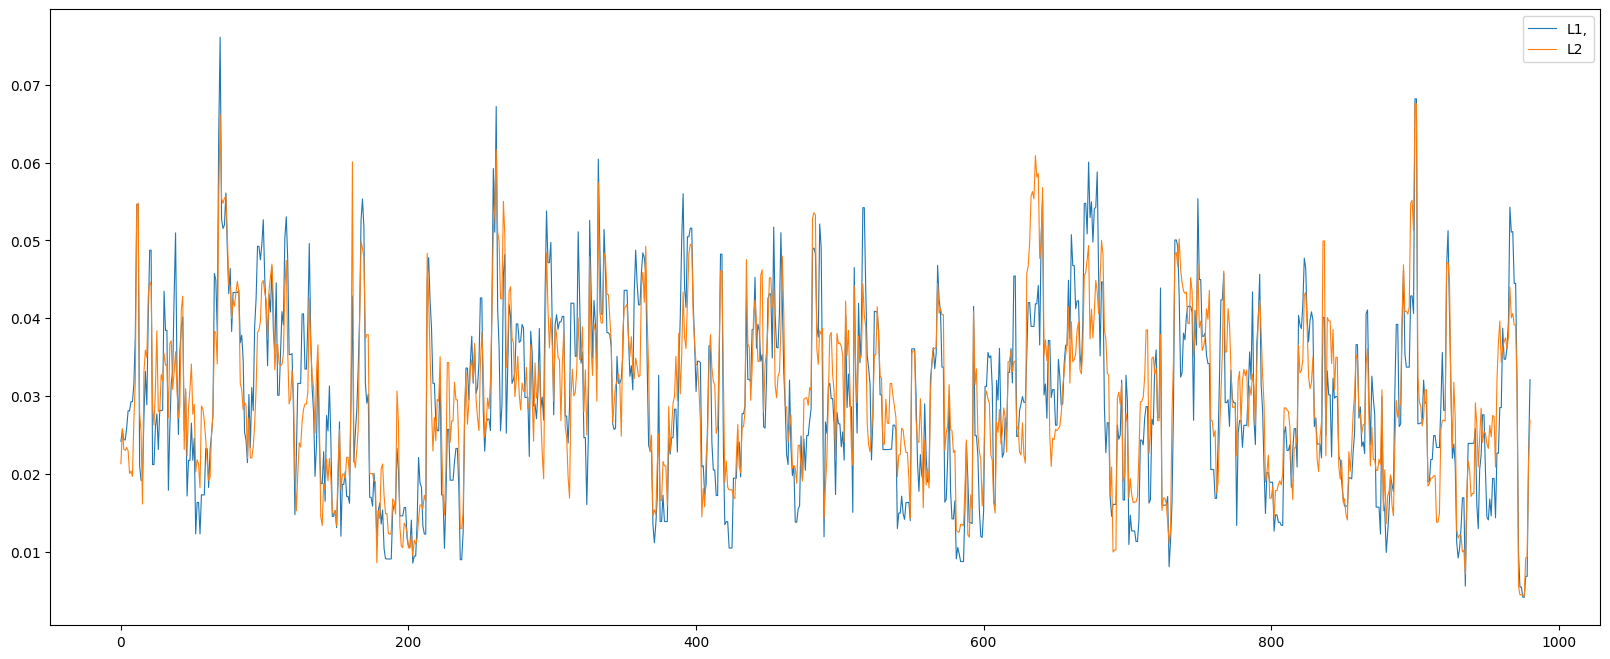

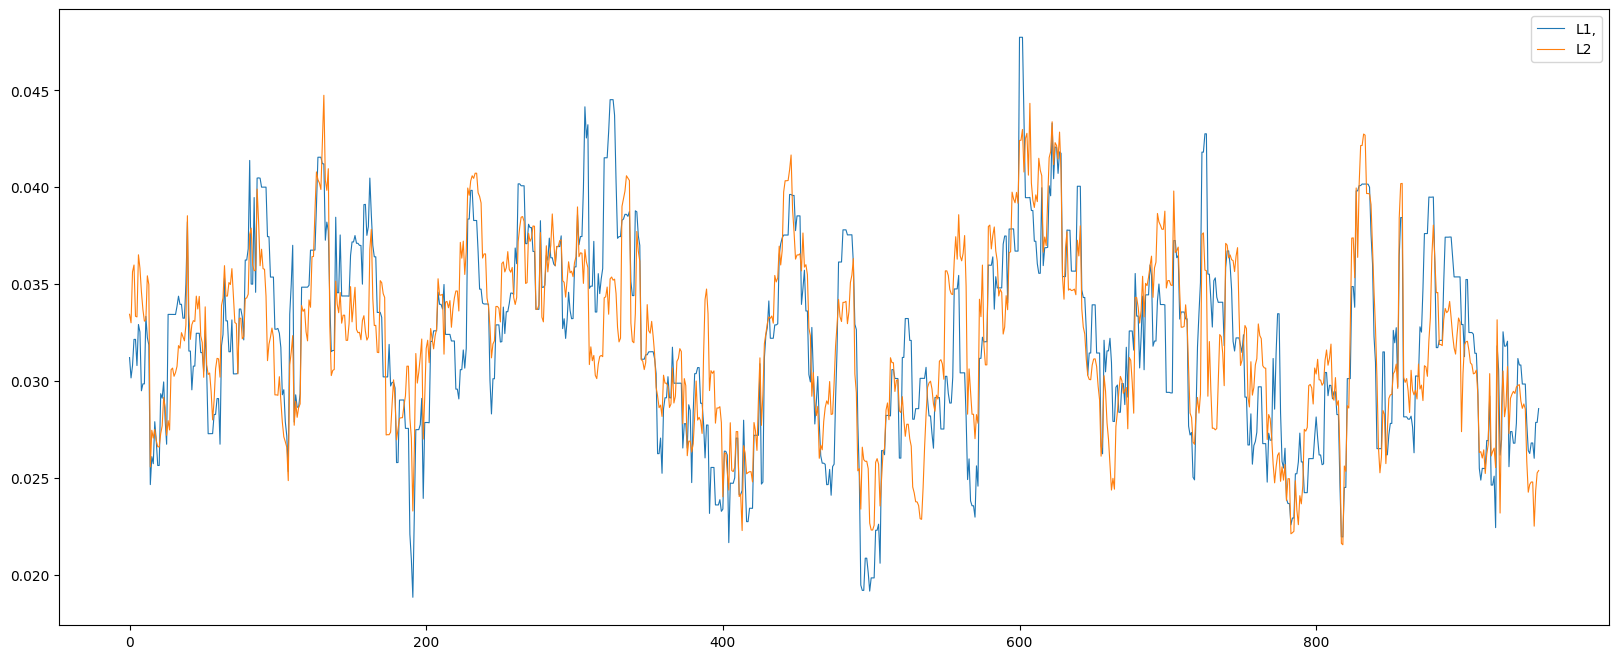

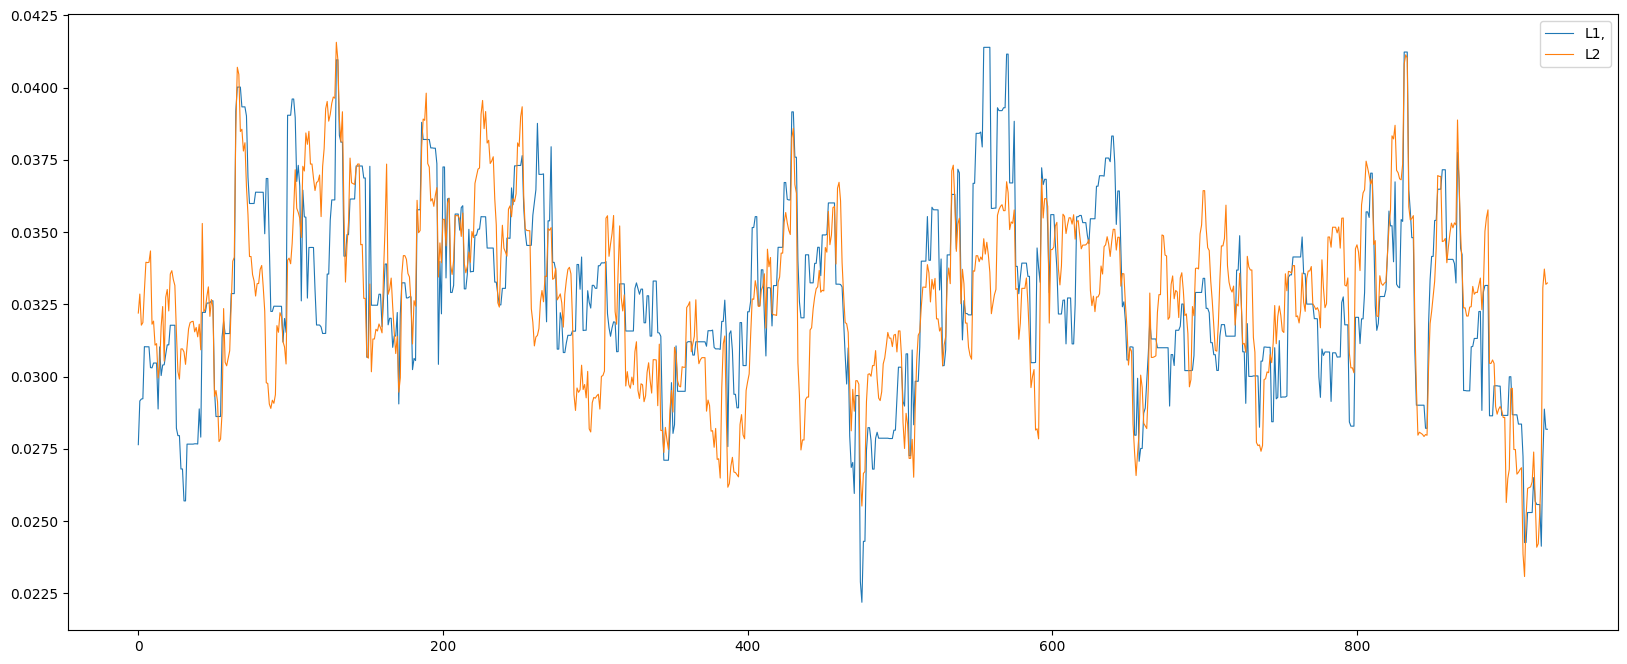

In [27]:
starting_index = 0
data_size = len(usable_data)
n_landscape = 5
window_sizes = [10, 20, 50, 75] # 100, 125, 150, ...
n_nodes = 1000
memory_saving = True

#plot for every window size
for window_size in window_sizes:
    sleep_wake(starting_index, data_size, n_landscape, window_size, n_nodes, memory_saving)